In [1]:
# adapted from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
# here we fit a linear regression model with one covariate, x
# the model is y = b0 + b1 * x + epsilon, where epsilon ~ Normal(0, 1)
# we estimate b0 and b1

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt


In [24]:
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )

device = "cpu"

PyTorch has some regression models prespecified, such as the below linear model, given as 
linear_model(in_features, out_features), thus in the following model we have one predictor variable (in_feature) and dependent variable (out_feature)

In [25]:

class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_model = nn.Linear(1, 1)

    def forward(self, x):
        y_hat = self.linear_model(x)
        return y_hat

We can also define custom models. Below we do the same linear regression model, but "by hand".

In [27]:
class customModel(nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters. These parameters are scalars, but tornch.randn accepts
        two dimension specifications so we can define them as matrices as well.
        """
        super().__init__()
        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x

In [28]:
model1 = RegressionModel().to(device)
print(model1)

model2 = customModel().to(device)
print(model2)

RegressionModel(
  (linear_model): Linear(in_features=1, out_features=1, bias=True)
)
customModel()


## Create Toy Data

In [29]:
n_train = 20
b0 = 10
b1 = 2
x_train = torch.rand(n_train, 1, device=device) * 10
y_train = torch.normal(mean= b0 + b1 * x_train, std=torch.ones((n_train, 1))).to(device)

#plt.plot(x_train, y_train, 'o')
#plt.show()

In [30]:
def get_model_coefs(model):
    model_params = list(model.parameters())
    model_params
    model_b1 = model_params[0].data
    model_b0 = model_params[1].data
    return model_b0, model_b1


In [31]:
init_b0, init_b1 = get_model_coefs(model1)
print(init_b0, init_b1)

y_hat_manual = init_b0 + init_b1 * x_train
y_hat_from_model = model2(x_train)

torch.all(y_hat_manual == y_hat_from_model)

tensor([-0.0863]) tensor([[0.9219]])


tensor(False)

# Predefined Linear Regression

This is from Evan's demo

tensor([-0.0863]) tensor([[0.9219]])
Epoch 1
-------------------------------
loss: 205.532227  [    1/   20]
Epoch 2
-------------------------------
loss: 47.813545  [    1/   20]
Epoch 3
-------------------------------
loss: 18.793060  [    1/   20]
Epoch 4
-------------------------------
loss: 11.736611  [    1/   20]
Epoch 5
-------------------------------
loss: 9.566935  [    1/   20]
Epoch 6
-------------------------------
loss: 8.757118  [    1/   20]
Epoch 7
-------------------------------
loss: 8.376892  [    1/   20]
Epoch 8
-------------------------------
loss: 8.141169  [    1/   20]
Epoch 9
-------------------------------
loss: 7.956438  [    1/   20]
Epoch 10
-------------------------------
loss: 7.791163  [    1/   20]
Epoch 11
-------------------------------
loss: 7.634583  [    1/   20]
Epoch 12
-------------------------------
loss: 7.483019  [    1/   20]
Epoch 13
-------------------------------
loss: 7.335119  [    1/   20]
Epoch 14
-------------------------------
los

/Users/bwrogers/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 79
-------------------------------
loss: 2.025174  [    1/   20]
Epoch 80
-------------------------------
loss: 1.987083  [    1/   20]
Epoch 81
-------------------------------
loss: 1.949737  [    1/   20]
Epoch 82
-------------------------------
loss: 1.913131  [    1/   20]
Epoch 83
-------------------------------
loss: 1.877258  [    1/   20]
Epoch 84
-------------------------------
loss: 1.842082  [    1/   20]
Epoch 85
-------------------------------
loss: 1.807597  [    1/   20]
Epoch 86
-------------------------------
loss: 1.773799  [    1/   20]
Epoch 87
-------------------------------
loss: 1.740672  [    1/   20]
Epoch 88
-------------------------------
loss: 1.708192  [    1/   20]
Epoch 89
-------------------------------
loss: 1.676344  [    1/   20]
Epoch 90
-------------------------------
loss: 1.645132  [    1/   20]
Epoch 91
-------------------------------
loss: 1.614524  [    1/   20]
Epoch 92
-------------------------------
loss: 1.584526  [    1/   20]
Epoch 

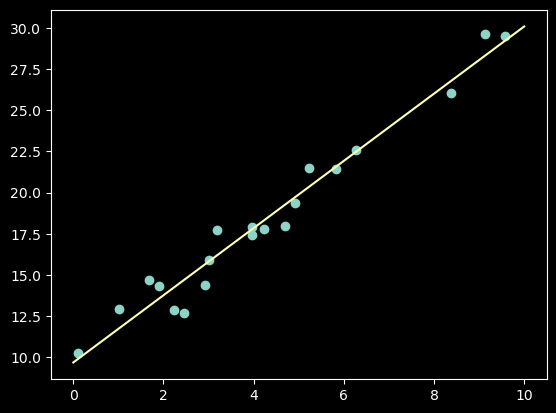

In [34]:
init_b0, init_b1 = get_model_coefs(model1)
print(init_b0, init_b1)

y_hat_manual = init_b0 + init_b1 * x_train
y_hat_from_model = model1(x_train)

torch.all(y_hat_manual == y_hat_from_model)

# create a Dataset with our training X's and Y's
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        '''
        Initialize dataset
        '''
        assert x.shape == y.shape
        self.x = x
        self.y = y
    
    def __len__(self):
        '''
        How many instances in the dataset?
        '''
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        '''
        Return instance at specified index
        '''
        return self.x[idx, ...], self.y[idx, 0]


train_loader = DataLoader(SimpleDataset(x_train, y_train))


# Function that does parameter estimation
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



# "hyperparameters"
# these describe how parameter optimization/estimation should work
learning_rate = 1e-3
batch_size=20
epochs = 1000

# loss function and method for optimizing the loss
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)

# do estimation
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model1, loss_fn, optimizer)

# inspect the parameter estimates
estimated_b0, estimated_b1 = get_model_coefs(model1)
print(estimated_b0, estimated_b1)

# make a plot
x_test = torch.arange(0, 11, dtype=torch.float32)[:, None]
y_hat = model1(x_test)

plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_hat.detach().numpy())
plt.show()



## Custom Defined Model

Here is the same as above but for the custom defined model

In [35]:
init_b0, init_b1 = get_model_coefs(model2)
print(init_b0, init_b1)

y_hat_manual = init_b0 + init_b1 * x_train
y_hat_from_model = model2(x_train)

torch.all(y_hat_manual == y_hat_from_model)



tensor([-0.3042]) tensor([0.5696])


tensor(False)

Epoch 1
-------------------------------
loss: 343.679718  [    1/   20]
Epoch 2
-------------------------------
loss: 67.138046  [    1/   20]
Epoch 3
-------------------------------
loss: 21.229980  [    1/   20]
Epoch 4
-------------------------------
loss: 11.242166  [    1/   20]
Epoch 5
-------------------------------
loss: 8.425598  [    1/   20]
Epoch 6
-------------------------------
loss: 7.453449  [    1/   20]
Epoch 7
-------------------------------
loss: 7.040898  [    1/   20]
Epoch 8
-------------------------------
loss: 6.812691  [    1/   20]
Epoch 9
-------------------------------
loss: 6.648214  [    1/   20]
Epoch 10
-------------------------------
loss: 6.507123  [    1/   20]
Epoch 11
-------------------------------
loss: 6.375720  [    1/   20]
Epoch 12
-------------------------------
loss: 6.249313  [    1/   20]
Epoch 13
-------------------------------
loss: 6.126241  [    1/   20]
Epoch 14
-------------------------------
loss: 6.005934  [    1/   20]
Epoch 15
-

/Users/bwrogers/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80
-------------------------------
loss: 1.674250  [    1/   20]
Epoch 81
-------------------------------
loss: 1.643073  [    1/   20]
Epoch 82
-------------------------------
loss: 1.612509  [    1/   20]
Epoch 83
-------------------------------
loss: 1.582553  [    1/   20]
Epoch 84
-------------------------------
loss: 1.553177  [    1/   20]
Epoch 85
-------------------------------
loss: 1.524383  [    1/   20]
Epoch 86
-------------------------------
loss: 1.496153  [    1/   20]
Epoch 87
-------------------------------
loss: 1.468472  [    1/   20]
Epoch 88
-------------------------------
loss: 1.441343  [    1/   20]
Epoch 89
-------------------------------
loss: 1.414740  [    1/   20]
Epoch 90
-------------------------------
loss: 1.388658  [    1/   20]
Epoch 91
-------------------------------
loss: 1.363082  [    1/   20]
Epoch 92
-------------------------------
loss: 1.338004  [    1/   20]
Epoch 93
-------------------------------
loss: 1.313425  [    1/   20]
Epoch 

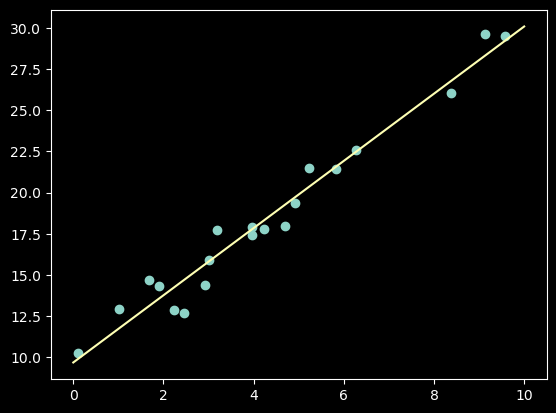

In [37]:
# loss function and method for optimizing the loss
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)

# do estimation
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model2, loss_fn, optimizer)

# inspect the parameter estimates
estimated_b0, estimated_b1 = get_model_coefs(model1)
print(estimated_b0, estimated_b1)

# make a plot
x_test = torch.arange(0, 11, dtype=torch.float32)[:, None]
y_hat = model2(x_test)

plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_hat.detach().numpy())
plt.show()